## 1-day Prediction

[*********************100%***********************]  1 of 1 completed



NEXT-DAY PREDICTION REPORT FOR NVDA

Report Date: 2025-03-23
Forecast For: 2025-03-24
Optimal ARIMA Parameters: (1, 1, 1)

Price Forecast:
Current Price (Last Close): $117.70
Forecasted Price: $117.77 (+0.06%)
95% Confidence Interval: $113.85 to $121.69

Trading Recommendation:
Action: HOLD
Confidence: 86.7%
Recommended Position Size: 0.0% of portfolio
Expected Price Change: +0.06%


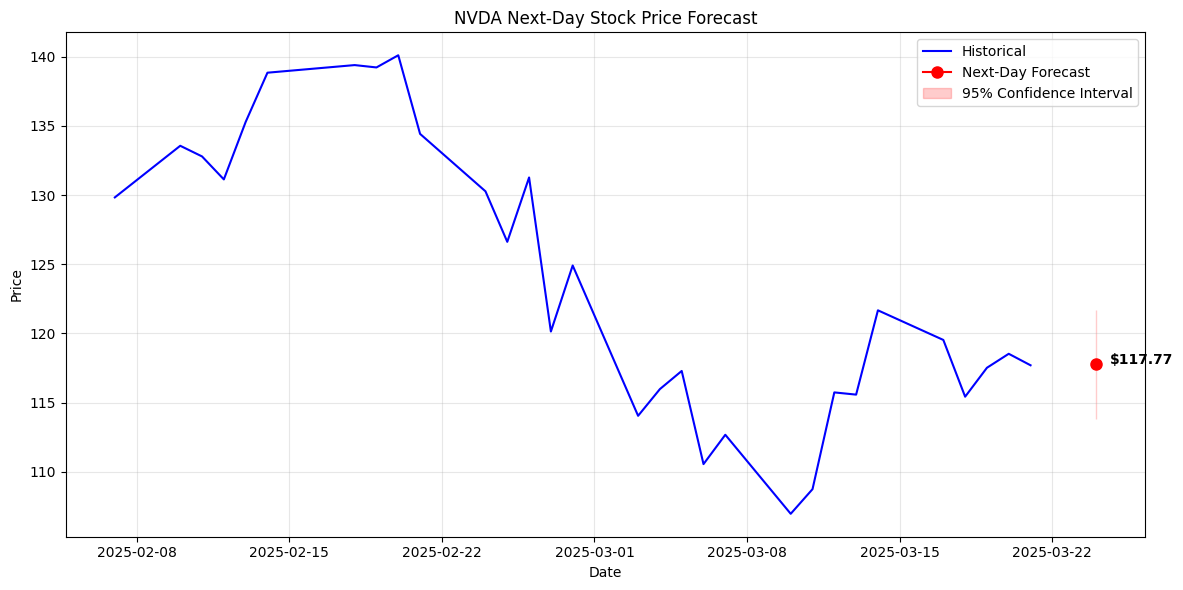

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
import logging
from datetime import datetime, timedelta
import os


os.environ['PYTHONWARNINGS'] = 'ignore'

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('StockForecast')

# Suppress specific warnings
warnings.filterwarnings('ignore')


class DataManager:
    """Handles data fetching, processing, and validation"""

    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.close_prices = None
        self.returns = None

    def fetch_data(self):
        """Fetch historical stock data from Yahoo Finance with error handling"""
        try:
            logger.info(f"Fetching data for {self.ticker} from {self.start_date} to {self.end_date}")
            self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)

            if self.data.empty:
                raise ValueError(f"No data available for {self.ticker}")

            self.close_prices = self.data['Close'].copy()
            self.returns = self.close_prices.pct_change().dropna()

            # Add technical indicators
            self._add_technical_indicators()

            logger.info(f"Successfully fetched {len(self.data)} days of data")
            return self.data

        except Exception as e:
            logger.error(f"Error fetching data: {str(e)}")
            raise

    def _add_technical_indicators(self):
        """Add technical indicators to the dataset"""
        # Simple moving averages
        self.data['SMA_5'] = self.data['Close'].rolling(window=5).mean()
        self.data['SMA_20'] = self.data['Close'].rolling(window=20).mean()

        # Relative Strength Index (RSI)
        delta = self.data['Close'].diff()
        gain = delta.where(delta > 0, 0).rolling(window=14).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
        rs = gain / loss
        self.data['RSI'] = 100 - (100 / (1 + rs))

        # MACD
        self.data['EMA_12'] = self.data['Close'].ewm(span=12).mean()
        self.data['EMA_26'] = self.data['Close'].ewm(span=26).mean()
        self.data['MACD'] = self.data['EMA_12'] - self.data['EMA_26']
        self.data['MACD_Signal'] = self.data['MACD'].ewm(span=9).mean()

        # Volatility
        self.data['Volatility'] = self.data['Close'].rolling(window=20).std()

        # Drop NaN values
        self.data = self.data.dropna()

    def check_stationarity(self, series=None):
        """Check stationarity using Augmented Dickey-Fuller test"""
        if series is None:
            series = self.close_prices

        result = adfuller(series.dropna())
        logger.info(f"ADF p-value: {result[1]:.4f}")

        return {
            'is_stationary': result[1] <= 0.05,
            'p_value': result[1],
            'critical_values': result[4]
        }

    def make_stationary(self, series=None, max_diff=2):
        """Transform series to stationary if needed"""
        if series is None:
            series = self.close_prices.copy()

        result = self.check_stationarity(series)
        d = 0
        transformed_series = series.copy()

        while not result['is_stationary'] and d < max_diff:
            d += 1
            transformed_series = transformed_series.diff().dropna()
            result = self.check_stationarity(transformed_series)
            logger.info(f"Applied differencing {d} time(s)")

        return {
            'series': transformed_series,
            'order_of_differencing': d,
            'is_stationary': result['is_stationary']
        }

    def get_train_test_split(self, test_size=0.2):
        """Split data into training and testing sets"""
        if self.close_prices is None:
            self.fetch_data()

        split_idx = int(len(self.close_prices) * (1 - test_size))
        train = self.close_prices.iloc[:split_idx]
        test = self.close_prices.iloc[split_idx:]

        return train, test


class ModelOptimizer:
    """Optimizes ARIMA model parameters and validates model performance"""

    def __init__(self, data_manager):
        self.data_manager = data_manager
        self.best_model = None
        self.best_params = None
        self.best_aic = float('inf')
        self.best_mse = float('inf')

    def find_optimal_params(self, p_range=(0, 5), d_range=(0, 2), q_range=(0, 5)):
        """Find optimal ARIMA parameters using grid search and cross-validation"""
        logger.info("Finding optimal ARIMA parameters...")

        # Get stationary series and recommended d value
        stat_result = self.data_manager.make_stationary()
        series = self.data_manager.close_prices
        recommended_d = stat_result['order_of_differencing']

        # Adjust d_range based on stationarity test
        d_values = list(range(min(d_range[0], recommended_d), min(d_range[1], recommended_d + 1) + 1))

        # Use ACF and PACF to guide parameter selection
        acf_values = acf(stat_result['series'], nlags=20)
        pacf_values = pacf(stat_result['series'], nlags=20)

        # Use significant lags in ACF to suggest q values
        significant_q = [i for i in range(1, min(21, q_range[1] + 1))
                         if abs(acf_values[i]) > 1.96/np.sqrt(len(stat_result['series']))]

        # Use significant lags in PACF to suggest p values
        significant_p = [i for i in range(1, min(21, p_range[1] + 1))
                         if abs(pacf_values[i]) > 1.96/np.sqrt(len(stat_result['series']))]

        # Create parameter combinations, prioritizing suggested values
        p_values = sorted(set(significant_p + list(range(p_range[0], p_range[1] + 1))))
        q_values = sorted(set(significant_q + list(range(q_range[0], q_range[1] + 1))))

        # Use time series cross-validation
        tscv = TimeSeriesSplit(n_splits=3)

        best_order = None
        best_score = float('inf')

        total_combinations = len(p_values) * len(d_values) * len(q_values)
        logger.info(f"Testing {total_combinations} parameter combinations")

        # Track progress
        progress = 0

        for p in p_values:
            for d in d_values:
                for q in q_values:
                    progress += 1
                    if progress % 10 == 0:
                        logger.info(f"Progress: {progress}/{total_combinations}")

                    order = (p, d, q)
                    cv_scores = []

                    try:
                        # Cross-validation
                        for train_idx, test_idx in tscv.split(series):
                            train = series.iloc[train_idx]
                            test = series.iloc[test_idx]

                            # Skip if too few samples after differencing
                            if len(train) <= p + d + q + 1:
                                continue

                            model = ARIMA(train, order=order).fit()
                            # Modified to focus on next-day forecasting
                            preds = model.forecast(steps=1)
                            if len(test) >= 1:  # Ensure we have at least one test point
                                mse = mean_squared_error([test.iloc[0]], [preds[0]])
                                cv_scores.append(mse)

                        if cv_scores:
                            avg_score = np.mean(cv_scores)

                            if avg_score < best_score:
                                best_score = avg_score
                                best_order = order
                                logger.info(f"New best order: {order}, MSE: {avg_score:.4f}")

                    except Exception as e:
                        logger.debug(f"Error with order {order}: {str(e)}")
                        continue

        if best_order:
            self.best_params = best_order
            logger.info(f"Optimal parameters found: {best_order}")
        else:
            # Fallback to a reasonable default
            self.best_params = (1, 1, 1)
            logger.warning("Could not find optimal parameters, using default (1,1,1)")

        return self.best_params

    def fit_model(self, order=None):
        """Fit ARIMA model with optimal or specified parameters"""
        if order is None:
            if self.best_params is None:
                self.find_optimal_params()
            order = self.best_params

        logger.info(f"Fitting ARIMA model with order {order}")

        try:
            model = ARIMA(self.data_manager.close_prices, order=order).fit()
            self.best_model = model
            self.best_aic = model.aic
            logger.info(f"Model fitted successfully. AIC: {model.aic:.2f}")
            return model

        except Exception as e:
            logger.error(f"Error fitting model: {str(e)}")
            raise

    def validate_model(self, model=None):
        """Validate model performance specifically for next-day predictions"""
        if model is None:
            if self.best_model is None:
                self.fit_model()
            model = self.best_model

        # Use the last 30 days for testing one-day-ahead forecasts
        validation_length = 30
        test_results = []

        # Get the data
        prices = self.data_manager.close_prices

        if len(prices) <= validation_length:
            validation_length = len(prices) // 3  # Use 1/3 of data if not enough

        # Perform walk-forward validation for one-day forecasts
        for i in range(validation_length):
            # Use all data up to this point
            train_end_idx = len(prices) - validation_length + i
            train = prices.iloc[:train_end_idx]

            if len(train) < 10:  # Ensure minimum data for model fitting
                continue

            # Fit model on training data
            try:
                test_model = ARIMA(train, order=self.best_params).fit()

                # Generate one-day forecast
                forecast = test_model.forecast(steps=1)[0]
                actual = prices.iloc[train_end_idx]

                test_results.append({
                    'date': prices.index[train_end_idx],
                    'actual': actual,
                    'forecast': forecast,
                    'error': actual - forecast
                })
            except Exception as e:
                logger.warning(f"Error in validation iteration {i}: {str(e)}")
                continue

        # Calculate error metrics
        if test_results:
            test_df = pd.DataFrame(test_results)

            mse = mean_squared_error(test_df['actual'], test_df['forecast'])
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(test_df['actual'], test_df['forecast'])
            mape = np.mean(np.abs((test_df['actual'] - test_df['forecast']) / test_df['actual'])) * 100

            logger.info(f"One-Day Forecast Validation Results:")
            logger.info(f"RMSE: {rmse:.2f}")
            logger.info(f"MAE: {mae:.2f}")
            logger.info(f"MAPE: {mape:.2f}%")

            return {
                'rmse': rmse,
                'mae': mae,
                'mape': mape,
                'test_results': test_df
            }
        else:
            logger.warning("No validation results produced")
            return None


class Forecaster:
    """Generates forecasts using optimized models - modified for one-day predictions"""

    def __init__(self, data_manager, model_optimizer):
        self.data_manager = data_manager
        self.model_optimizer = model_optimizer
        self.forecast_data = None

    def generate_forecast(self, include_confidence=True, alpha=0.05):
        """Generate single day price forecast with confidence intervals"""
        if self.model_optimizer.best_model is None:
            self.model_optimizer.fit_model()

        logger.info("Generating next-day forecast")

        # Generate forecast for just one day
        forecast_result = self.model_optimizer.best_model.get_forecast(steps=1)

        # Get point predictions
        point_forecast = forecast_result.predicted_mean

        # Get confidence intervals if requested
        if include_confidence:
            conf_intervals = forecast_result.conf_int(alpha=alpha)
            lower_bound = conf_intervals.iloc[:, 0]
            upper_bound = conf_intervals.iloc[:, 1]
        else:
            lower_bound = None
            upper_bound = None

        # Get next business day
        last_date = pd.to_datetime(self.data_manager.end_date)
        next_day = last_date + pd.Timedelta(days=1)
        # Ensure it's a business day (skip weekends)
        while next_day.weekday() > 4:  # 5 = Saturday, 6 = Sunday
            next_day = next_day + pd.Timedelta(days=1)

        # Create forecast DataFrame
        forecast_df = pd.DataFrame({
            'Forecasted_Price': point_forecast.values
        }, index=[next_day])

        if include_confidence:
            forecast_df['Lower_Bound'] = lower_bound.values
            forecast_df['Upper_Bound'] = upper_bound.values

        self.forecast_data = forecast_df
        logger.info(f"Next-day forecast generated successfully for {next_day.strftime('%Y-%m-%d')}")

        return forecast_df

    def plot_forecast(self, historical_periods=30, save_path=None):
        """Plot historical data and next-day forecast with confidence intervals"""
        if self.forecast_data is None:
            raise ValueError("No forecast data available. Generate forecast first.")

        plt.figure(figsize=(12, 6))

        # Plot historical data
        historical = self.data_manager.close_prices.iloc[-historical_periods:]
        plt.plot(historical.index, historical, label='Historical', color='blue')

        # Plot forecast
        plt.plot(self.forecast_data.index, self.forecast_data['Forecasted_Price'],
                 label='Next-Day Forecast', color='red', marker='o', markersize=8)

        # Plot confidence intervals if available
        if 'Lower_Bound' in self.forecast_data.columns:
            plt.fill_between(
                self.forecast_data.index,
                self.forecast_data['Lower_Bound'],
                self.forecast_data['Upper_Bound'],
                color='red', alpha=0.2, label='95% Confidence Interval'
            )

        plt.title(f"{self.data_manager.ticker} Next-Day Stock Price Forecast")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Add annotation with the predicted price
        forecast_price = self.forecast_data['Forecasted_Price'].iloc[0]
        plt.annotate(f'${forecast_price:.2f}',
                    xy=(self.forecast_data.index[0], forecast_price),
                    xytext=(10, 0), textcoords='offset points',
                    fontsize=10, fontweight='bold')

        if save_path:
            plt.savefig(save_path)
            logger.info(f"Plot saved to {save_path}")

        plt.tight_layout()
        return plt


class TradingStrategy:
    """Implements trading strategy based on next-day forecast"""

    def __init__(self, initial_balance=10000, risk_tolerance='medium'):
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.shares = 0
        self.risk_tolerance = risk_tolerance
        self.portfolio_values = []
        self.transactions = []

        # Set risk parameters based on tolerance
        self._set_risk_parameters()

    def _set_risk_parameters(self):
        """Set trading parameters based on risk tolerance"""
        if self.risk_tolerance == 'low':
            self.initial_investment_pct = 0.3
            self.buy_threshold_pct = 0.02
            self.sell_threshold_pct = 0.01
            self.max_position_pct = 0.5
        elif self.risk_tolerance == 'medium':
            self.initial_investment_pct = 0.5
            self.buy_threshold_pct = 0.01
            self.sell_threshold_pct = 0.015
            self.max_position_pct = 0.7
        elif self.risk_tolerance == 'high':
            self.initial_investment_pct = 0.7
            self.buy_threshold_pct = 0.005
            self.sell_threshold_pct = 0.02
            self.max_position_pct = 0.9
        else:
            raise ValueError("Risk tolerance must be 'low', 'medium', or 'high'")

    def recommend_action(self, forecast_df, historical_df=None):
        """Generate trading recommendation based on next-day forecast"""
        logger.info(f"Generating trading recommendation with {self.risk_tolerance} risk tolerance")

        # Get the forecasted price for next day
        next_price = forecast_df['Forecasted_Price'].iloc[0]
        if isinstance(next_price, pd.Series):
            next_price = next_price.item()  # Convert to scalar if needed

        # Get the current price (last available historical price)
        if historical_df is None:
            raise ValueError("Historical data is required for generating recommendations")

        current_price = historical_df['Close'].iloc[-1]
        if isinstance(current_price, pd.Series):
            current_price = current_price.item()  # Convert to scalar if needed

        # Calculate the expected price change
        price_change_pct = (next_price - current_price) / current_price

        # Use confidence intervals for risk assessment if available
        if 'Lower_Bound' in forecast_df.columns and 'Upper_Bound' in forecast_df.columns:
            lower_bound = forecast_df['Lower_Bound'].iloc[0]
            upper_bound = forecast_df['Upper_Bound'].iloc[0]

            if isinstance(lower_bound, pd.Series):
                lower_bound = lower_bound.item()
            if isinstance(upper_bound, pd.Series):
                upper_bound = upper_bound.item()

            uncertainty = (upper_bound - lower_bound) / next_price
        else:
            uncertainty = 0.05  # Default uncertainty

        # Adjust confidence based on uncertainty
        confidence = 1 - min(1.0, uncertainty * 2)
        confidence = max(0.1, confidence)  # Clamp between 0.1 and 1.0

        # Determine action based on price change and risk parameters
        if price_change_pct > self.buy_threshold_pct * confidence:
            action = "BUY"
            strength = min(1.0, price_change_pct / (self.buy_threshold_pct * 2))
        elif price_change_pct < -self.sell_threshold_pct * confidence:
            action = "SELL"
            strength = min(1.0, abs(price_change_pct) / (self.sell_threshold_pct * 2))
        else:
            action = "HOLD"
            strength = 0.0

        # Determine position size based on strength and risk tolerance
        if action in ["BUY", "SELL"]:
            position_size = self.initial_investment_pct * strength * confidence
        else:
            position_size = 0.0

        recommendation = {
            'action': action,
            'confidence': confidence * 100,  # Convert to percentage
            'strength': strength * 100,  # Convert to percentage
            'current_price': current_price,
            'forecasted_price': next_price,
            'price_change_pct': price_change_pct * 100,  # Convert to percentage
            'position_size_pct': position_size * 100,  # Convert to percentage
            'uncertainty': uncertainty * 100  # Convert to percentage
        }

        logger.info(f"Recommendation: {action} with {confidence*100:.1f}% confidence")
        return recommendation


class StockAnalysisSystem:
    """Main class that coordinates the entire stock analysis system - modified for next-day prediction"""

    def __init__(self, ticker, start_date, end_date, initial_balance=10000, risk_tolerance='medium'):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.initial_balance = initial_balance
        self.risk_tolerance = risk_tolerance

        # Initialize components
        self.data_manager = DataManager(ticker, start_date, end_date)
        self.model_optimizer = None
        self.forecaster = None
        self.trading_strategy = None

    def run_analysis(self, validate_model=True):
        """Run the complete analysis pipeline for next-day prediction"""
        logger.info(f"Starting next-day analysis for {self.ticker}")

        # Step 1: Fetch and prepare data
        self.data_manager.fetch_data()

        # Step 2: Optimize model
        self.model_optimizer = ModelOptimizer(self.data_manager)
        self.model_optimizer.find_optimal_params()
        self.model_optimizer.fit_model()

        # Step 3: Validate model if requested
        if validate_model:
            validation_results = self.model_optimizer.validate_model()
            if validation_results:
                logger.info(f"Model RMSE: {validation_results['rmse']:.2f}")

        # Step 4: Generate forecast for next day only
        self.forecaster = Forecaster(self.data_manager, self.model_optimizer)
        forecast = self.forecaster.generate_forecast()

        # Step 5: Generate trading recommendation
        self.trading_strategy = TradingStrategy(
            initial_balance=self.initial_balance,
            risk_tolerance=self.risk_tolerance
        )
        recommendation = self.trading_strategy.recommend_action(forecast, self.data_manager.data)

        return {
            'forecast': forecast,
            'recommendation': recommendation,
            'model': self.model_optimizer.best_model,
            'optimal_params': self.model_optimizer.best_params
        }

    def generate_report(self, results=None, output_dir=None):
        """Generate comprehensive report for next-day prediction"""
        if results is None:
            results = self.run_analysis()

        if output_dir is None:
            output_dir = '.'

        # Create visualization
        forecast_plot = self.forecaster.plot_forecast()

        # Get current date for the report
        current_date = datetime.now().strftime('%Y-%m-%d')
        next_business_day = results['forecast'].index[0].strftime('%Y-%m-%d')

        # Print summary
        print("\n" + "="*50)
        print(f"NEXT-DAY PREDICTION REPORT FOR {self.ticker}")
        print("="*50)

        print(f"\nReport Date: {current_date}")
        print(f"Forecast For: {next_business_day}")
        print(f"Optimal ARIMA Parameters: {results['optimal_params']}")

        print("\nPrice Forecast:")
        forecast_price = results['forecast']['Forecasted_Price'].iloc[0]
        if isinstance(forecast_price, pd.Series):
            forecast_price = forecast_price.item()

        current_price = self.data_manager.close_prices.iloc[-1]
        if isinstance(current_price, pd.Series):
            current_price = current_price.item()

        change_pct = ((forecast_price - current_price) / current_price) * 100

        print(f"Current Price (Last Close): ${float(current_price):.2f}")
        print(f"Forecasted Price: ${float(forecast_price):.2f} ({float(change_pct):+.2f}%)")

        if 'Lower_Bound' in results['forecast'].columns:
            lower = results['forecast']['Lower_Bound'].iloc[0]
            if isinstance(lower, pd.Series):
                lower = lower.item()

            upper = results['forecast']['Upper_Bound'].iloc[0]
            if isinstance(upper, pd.Series):
                upper = upper.item()

            print(f"95% Confidence Interval: ${float(lower):.2f} to ${float(upper):.2f}")

        print("\nTrading Recommendation:")
        rec = results['recommendation']

        # Extract values from rec, converting any Series to scalars
        action = rec['action']

        confidence = rec['confidence']
        if isinstance(confidence, pd.Series):
            confidence = confidence.item()

        position_size_pct = rec['position_size_pct']
        if isinstance(position_size_pct, pd.Series):
            position_size_pct = position_size_pct.item()

        price_change_pct = rec['price_change_pct']
        if isinstance(price_change_pct, pd.Series):
            price_change_pct = price_change_pct.item()

        print(f"Action: {action}")
        print(f"Confidence: {float(confidence):.1f}%")
        print(f"Recommended Position Size: {float(position_size_pct):.1f}% of portfolio")
        print(f"Expected Price Change: {float(price_change_pct):+.2f}%")

        if action == 'BUY':
            shares = int((self.initial_balance * position_size_pct / 100) // current_price)
            cost = shares * current_price
            print(f"Suggested Buy: {shares} shares at approximately ${float(current_price):.2f} (${float(cost):.2f})")
        elif action == 'SELL':
            print(f"Suggested Sell: Consider selling {float(position_size_pct):.1f}% of your position")

        return results


def main():
    """Main function to run the stock analysis system for next-day prediction"""
    # Configuration
    TICKER = 'NVDA'
    START_DATE = '2020-01-01'
    END_DATE = '2025-03-23'  # Use current date in practice
    INITIAL_BALANCE = 10000
    RISK_TOLERANCE = 'medium'  # Options: 'low', 'medium', 'high'

    try:
        # Initialize and run system
        system = StockAnalysisSystem(
            ticker=TICKER,
            start_date=START_DATE,
            end_date=END_DATE,
            initial_balance=INITIAL_BALANCE,
            risk_tolerance=RISK_TOLERANCE
        )

        # Run analysis for next-day prediction
        results = system.run_analysis()

        # Generate report
        system.generate_report(results)

    except Exception as e:
        logger.error(f"Error in main execution: {str(e)}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()

## 5-Day Prediction

[*********************100%***********************]  1 of 1 completed



ANALYSIS REPORT FOR NVDA

Forecast Period: 2025-03-24 to 2025-03-28
Optimal ARIMA Parameters: (5, 2, 4)

Price Forecast:
            Forecasted_Price  Lower_Bound  Upper_Bound
2025-03-24        118.178138   114.271691   122.084585
2025-03-25        118.415812   113.123749   123.707875
2025-03-26        118.267603   111.606669   124.928538
2025-03-27        118.105928   110.455826   125.756030
2025-03-28        118.522696   109.972365   127.073026

Trading Summary:
Initial Balance: $10000.00
Final Portfolio Value: $10009.99
Return: 0.10%
Total Transactions: 1 (1 buys, 0 sells)

Detailed Trading Decisions:
        Date       Price         Decision  Portfolio_Value
0 2025-03-24  118.178138  BUY 29 @ 118.18     10000.000000
1 2025-03-25  118.415812             HOLD     10006.892559
2 2025-03-26  118.267603             HOLD     10002.594497
3 2025-03-27  118.105928             HOLD      9997.905923
4 2025-03-28  118.522696             HOLD     10009.992171


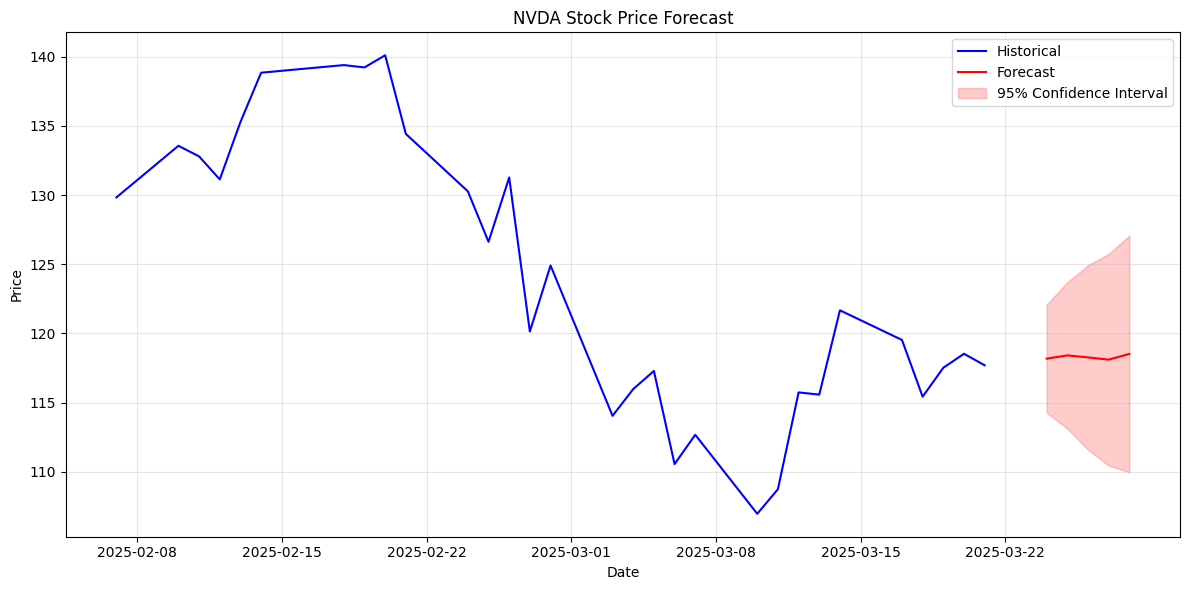

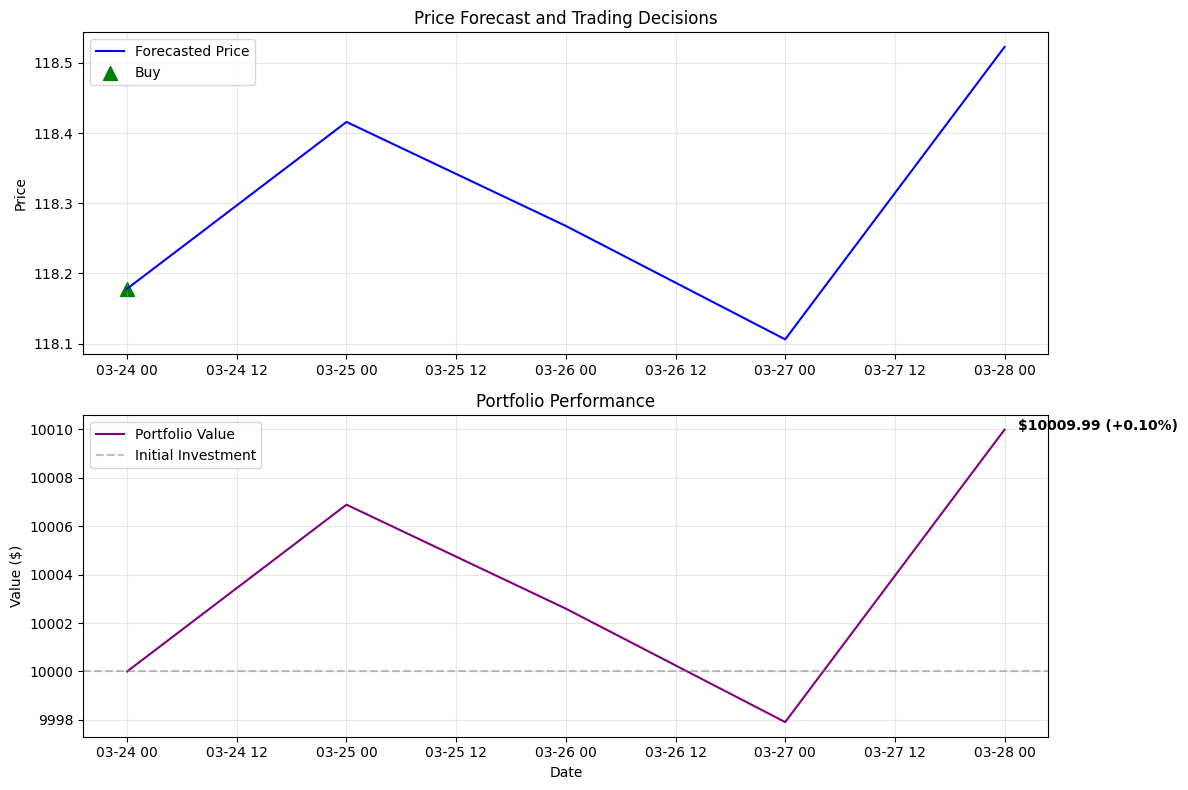

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
import logging
from datetime import datetime, timedelta

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('StockForecast')

# Suppress specific warnings
warnings.filterwarnings('ignore')


class DataManager:
    """Handles data fetching, processing, and validation"""

    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.close_prices = None
        self.returns = None

    def fetch_data(self):
        """Fetch historical stock data from Yahoo Finance with error handling"""
        try:
            logger.info(f"Fetching data for {self.ticker} from {self.start_date} to {self.end_date}")
            self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)

            if self.data.empty:
                raise ValueError(f"No data available for {self.ticker}")

            self.close_prices = self.data['Close'].copy()
            self.returns = self.close_prices.pct_change().dropna()

            # Add technical indicators
            self._add_technical_indicators()

            logger.info(f"Successfully fetched {len(self.data)} days of data")
            return self.data

        except Exception as e:
            logger.error(f"Error fetching data: {str(e)}")
            raise

    def _add_technical_indicators(self):
        """Add technical indicators to the dataset"""
        # Simple moving averages
        self.data['SMA_5'] = self.data['Close'].rolling(window=5).mean()
        self.data['SMA_20'] = self.data['Close'].rolling(window=20).mean()

        # Relative Strength Index (RSI)
        delta = self.data['Close'].diff()
        gain = delta.where(delta > 0, 0).rolling(window=14).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
        rs = gain / loss
        self.data['RSI'] = 100 - (100 / (1 + rs))

        # MACD
        self.data['EMA_12'] = self.data['Close'].ewm(span=12).mean()
        self.data['EMA_26'] = self.data['Close'].ewm(span=26).mean()
        self.data['MACD'] = self.data['EMA_12'] - self.data['EMA_26']
        self.data['MACD_Signal'] = self.data['MACD'].ewm(span=9).mean()

        # Volatility
        self.data['Volatility'] = self.data['Close'].rolling(window=20).std()

        # Drop NaN values
        self.data = self.data.dropna()

    def check_stationarity(self, series=None):
        """Check stationarity using Augmented Dickey-Fuller test"""
        if series is None:
            series = self.close_prices

        result = adfuller(series.dropna())
        logger.info(f"ADF p-value: {result[1]:.4f}")

        return {
            'is_stationary': result[1] <= 0.05,
            'p_value': result[1],
            'critical_values': result[4]
        }

    def make_stationary(self, series=None, max_diff=2):
        """Transform series to stationary if needed"""
        if series is None:
            series = self.close_prices.copy()

        result = self.check_stationarity(series)
        d = 0
        transformed_series = series.copy()

        while not result['is_stationary'] and d < max_diff:
            d += 1
            transformed_series = transformed_series.diff().dropna()
            result = self.check_stationarity(transformed_series)
            logger.info(f"Applied differencing {d} time(s)")

        return {
            'series': transformed_series,
            'order_of_differencing': d,
            'is_stationary': result['is_stationary']
        }

    def get_train_test_split(self, test_size=0.2):
        """Split data into training and testing sets"""
        if self.close_prices is None:
            self.fetch_data()

        split_idx = int(len(self.close_prices) * (1 - test_size))
        train = self.close_prices.iloc[:split_idx]
        test = self.close_prices.iloc[split_idx:]

        return train, test


class ModelOptimizer:
    """Optimizes ARIMA model parameters and validates model performance"""

    def __init__(self, data_manager):
        self.data_manager = data_manager
        self.best_model = None
        self.best_params = None
        self.best_aic = float('inf')
        self.best_mse = float('inf')

    def find_optimal_params(self, p_range=(0, 5), d_range=(0, 2), q_range=(0, 5)):
        """Find optimal ARIMA parameters using grid search and cross-validation"""
        logger.info("Finding optimal ARIMA parameters...")

        # Get stationary series and recommended d value
        stat_result = self.data_manager.make_stationary()
        series = self.data_manager.close_prices
        recommended_d = stat_result['order_of_differencing']

        # Adjust d_range based on stationarity test
        d_values = list(range(min(d_range[0], recommended_d), min(d_range[1], recommended_d + 1) + 1))

        # Use ACF and PACF to guide parameter selection
        acf_values = acf(stat_result['series'], nlags=20)
        pacf_values = pacf(stat_result['series'], nlags=20)

        # Use significant lags in ACF to suggest q values
        significant_q = [i for i in range(1, min(21, q_range[1] + 1))
                         if abs(acf_values[i]) > 1.96/np.sqrt(len(stat_result['series']))]

        # Use significant lags in PACF to suggest p values
        significant_p = [i for i in range(1, min(21, p_range[1] + 1))
                         if abs(pacf_values[i]) > 1.96/np.sqrt(len(stat_result['series']))]

        # Create parameter combinations, prioritizing suggested values
        p_values = sorted(set(significant_p + list(range(p_range[0], p_range[1] + 1))))
        q_values = sorted(set(significant_q + list(range(q_range[0], q_range[1] + 1))))

        # Use time series cross-validation
        tscv = TimeSeriesSplit(n_splits=3)

        best_order = None
        best_score = float('inf')

        total_combinations = len(p_values) * len(d_values) * len(q_values)
        logger.info(f"Testing {total_combinations} parameter combinations")

        # Track progress
        progress = 0

        for p in p_values:
            for d in d_values:
                for q in q_values:
                    progress += 1
                    if progress % 10 == 0:
                        logger.info(f"Progress: {progress}/{total_combinations}")

                    order = (p, d, q)
                    cv_scores = []

                    try:
                        # Cross-validation
                        for train_idx, test_idx in tscv.split(series):
                            train = series.iloc[train_idx]
                            test = series.iloc[test_idx]

                            # Skip if too few samples after differencing
                            if len(train) <= p + d + q + 1:
                                continue

                            model = ARIMA(train, order=order).fit()
                            preds = model.forecast(steps=len(test))
                            mse = mean_squared_error(test, preds)
                            cv_scores.append(mse)

                        if cv_scores:
                            avg_score = np.mean(cv_scores)

                            if avg_score < best_score:
                                best_score = avg_score
                                best_order = order
                                logger.info(f"New best order: {order}, MSE: {avg_score:.4f}")

                    except Exception as e:
                        logger.debug(f"Error with order {order}: {str(e)}")
                        continue

        if best_order:
            self.best_params = best_order
            logger.info(f"Optimal parameters found: {best_order}")
        else:
            # Fallback to a reasonable default
            self.best_params = (1, 1, 1)
            logger.warning("Could not find optimal parameters, using default (1,1,1)")

        return self.best_params

    def fit_model(self, order=None):
        """Fit ARIMA model with optimal or specified parameters"""
        if order is None:
            if self.best_params is None:
                self.find_optimal_params()
            order = self.best_params

        logger.info(f"Fitting ARIMA model with order {order}")

        try:
            model = ARIMA(self.data_manager.close_prices, order=order).fit()
            self.best_model = model
            self.best_aic = model.aic
            logger.info(f"Model fitted successfully. AIC: {model.aic:.2f}")
            return model

        except Exception as e:
            logger.error(f"Error fitting model: {str(e)}")
            raise

    def validate_model(self, model=None, test_size=0.2):
        """Validate model performance on test data"""
        if model is None:
            if self.best_model is None:
                self.fit_model()
            model = self.best_model

        train, test = self.data_manager.get_train_test_split(test_size)

        # Generate predictions for test period
        preds = model.forecast(steps=len(test))

        # Calculate error metrics
        mse = mean_squared_error(test, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test, preds)
        mape = np.mean(np.abs((test - preds) / test)) * 100

        logger.info(f"Model Validation Results:")
        logger.info(f"RMSE: {rmse:.2f}")
        logger.info(f"MAE: {mae:.2f}")
        logger.info(f"MAPE: {mape:.2f}%")

        return {
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'test': test,
            'predictions': preds
        }


class Forecaster:
    """Generates forecasts using optimized models"""

    def __init__(self, data_manager, model_optimizer):
        self.data_manager = data_manager
        self.model_optimizer = model_optimizer
        self.forecast_data = None

    def generate_forecast(self, steps=5, include_confidence=True, alpha=0.05):
        """Generate price forecast with confidence intervals"""
        if self.model_optimizer.best_model is None:
            self.model_optimizer.fit_model()

        logger.info(f"Generating {steps}-day forecast")

        # Generate forecast
        forecast_result = self.model_optimizer.best_model.get_forecast(steps=steps)

        # Get point predictions
        point_forecast = forecast_result.predicted_mean

        # Get confidence intervals if requested
        if include_confidence:
            conf_intervals = forecast_result.conf_int(alpha=alpha)
            lower_bound = conf_intervals.iloc[:, 0]
            upper_bound = conf_intervals.iloc[:, 1]
        else:
            lower_bound = None
            upper_bound = None

        # Generate business days for forecast period
        last_date = pd.to_datetime(self.data_manager.end_date)
        forecast_dates = pd.date_range(
            start=last_date + pd.Timedelta(days=1),
            periods=steps,
            freq='B'
        )

        # Create forecast DataFrame
        forecast_df = pd.DataFrame({
            'Forecasted_Price': point_forecast.values
        }, index=forecast_dates)

        if include_confidence:
            forecast_df['Lower_Bound'] = lower_bound.values
            forecast_df['Upper_Bound'] = upper_bound.values

        self.forecast_data = forecast_df
        logger.info(f"Forecast generated successfully")

        return forecast_df

    def plot_forecast(self, historical_periods=30, save_path=None):
        """Plot historical data and forecast with confidence intervals"""
        if self.forecast_data is None:
            raise ValueError("No forecast data available. Generate forecast first.")

        plt.figure(figsize=(12, 6))

        # Plot historical data
        historical = self.data_manager.close_prices.iloc[-historical_periods:]
        plt.plot(historical.index, historical, label='Historical', color='blue')

        # Plot forecast
        plt.plot(self.forecast_data.index, self.forecast_data['Forecasted_Price'],
                 label='Forecast', color='red')

        # Plot confidence intervals if available
        if 'Lower_Bound' in self.forecast_data.columns:
            plt.fill_between(
                self.forecast_data.index,
                self.forecast_data['Lower_Bound'],
                self.forecast_data['Upper_Bound'],
                color='red', alpha=0.2, label='95% Confidence Interval'
            )

        plt.title(f"{self.data_manager.ticker} Stock Price Forecast")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)

        if save_path:
            plt.savefig(save_path)
            logger.info(f"Plot saved to {save_path}")

        plt.tight_layout()
        return plt


class TradingStrategy:
    """Implements trading strategies based on forecasts and technical indicators"""

    def __init__(self, initial_balance=10000, risk_tolerance='medium'):
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.shares = 0
        self.risk_tolerance = risk_tolerance
        self.portfolio_values = []
        self.transactions = []

        # Set risk parameters based on tolerance
        self._set_risk_parameters()

    def _set_risk_parameters(self):
        """Set trading parameters based on risk tolerance"""
        if self.risk_tolerance == 'low':
            self.initial_investment_pct = 0.3
            self.buy_threshold_pct = 0.02
            self.sell_threshold_pct = 0.01
            self.max_position_pct = 0.5
        elif self.risk_tolerance == 'medium':
            self.initial_investment_pct = 0.5
            self.buy_threshold_pct = 0.01
            self.sell_threshold_pct = 0.015
            self.max_position_pct = 0.7
        elif self.risk_tolerance == 'high':
            self.initial_investment_pct = 0.7
            self.buy_threshold_pct = 0.005
            self.sell_threshold_pct = 0.02
            self.max_position_pct = 0.9
        else:
            raise ValueError("Risk tolerance must be 'low', 'medium', or 'high'")

    def execute_strategy(self, forecast_df, historical_df=None):
        """Execute trading strategy based on price forecasts and technical indicators"""
        logger.info(f"Executing trading strategy with {self.risk_tolerance} risk tolerance")

        decisions = []
        dates = []
        prices = []
        confidence_signals = []

        # Reset portfolio for new simulation
        self.balance = self.initial_balance
        self.shares = 0
        self.portfolio_values = []
        self.transactions = []

        # Prepare forecast data
        forecast_prices = forecast_df['Forecasted_Price']

        # Use confidence intervals if available for risk assessment
        if 'Lower_Bound' in forecast_df.columns and 'Upper_Bound' in forecast_df.columns:
            uncertainty = (forecast_df['Upper_Bound'] - forecast_df['Lower_Bound']) / forecast_df['Forecasted_Price']
        else:
            uncertainty = pd.Series([0.05] * len(forecast_prices), index=forecast_prices.index)

        # Analyze price trends in forecast
        price_trends = forecast_prices.pct_change().fillna(0)

        # Add volatility-based position sizing
        average_uncertainty = uncertainty.mean()

        for i, (date, price) in enumerate(forecast_prices.items()):
            current_uncertainty = uncertainty.iloc[i]
            dates.append(date)
            prices.append(price)

            # Calculate confidence signal (higher means more confident)
            confidence = 1 - (current_uncertainty / (average_uncertainty * 2))
            confidence = max(0.1, min(1.0, confidence))  # Clamp between 0.1 and 1.0
            confidence_signals.append(confidence)

            # Initial investment
            if i == 0:
                # Adjust initial investment based on confidence
                adjusted_investment_pct = self.initial_investment_pct * confidence
                investment = self.balance * adjusted_investment_pct
                shares_bought = int(investment // price)

                if shares_bought > 0:
                    cost = shares_bought * price
                    self.balance -= cost
                    self.shares += shares_bought
                    decisions.append(f"BUY {shares_bought} @ {price:.2f}")
                    self.transactions.append({
                        'date': date,
                        'type': 'BUY',
                        'shares': shares_bought,
                        'price': price,
                        'amount': cost
                    })
                else:
                    decisions.append("HOLD")
            else:
                prev_price = forecast_prices.iloc[i-1]
                price_change_pct = (price - prev_price) / prev_price

                # Calculate predicted trend strength
                trend_strength = abs(price_change_pct) * confidence

                # Buy signal: positive trend with strength above threshold
                if price_change_pct > self.buy_threshold_pct * confidence:
                    # Check if we're below max position size
                    portfolio_value = self.balance + self.shares * price
                    position_value = self.shares * price
                    position_pct = position_value / portfolio_value if portfolio_value > 0 else 0

                    if position_pct < self.max_position_pct:
                        # Size position based on trend strength
                        investment_pct = min(0.2, trend_strength * 2)
                        investment = self.balance * investment_pct
                        shares_bought = int(investment // price)

                        if shares_bought > 0:
                            cost = shares_bought * price
                            self.balance -= cost
                            self.shares += shares_bought
                            decisions.append(f"BUY {shares_bought} @ {price:.2f}")
                            self.transactions.append({
                                'date': date,
                                'type': 'BUY',
                                'shares': shares_bought,
                                'price': price,
                                'amount': cost
                            })
                        else:
                            decisions.append("HOLD")
                    else:
                        decisions.append("HOLD - Max position reached")

                # Sell signal: negative trend with strength above threshold
                elif price_change_pct < -self.sell_threshold_pct * confidence:
                    if self.shares > 0:
                        # Scale selling amount based on trend strength
                        sell_pct = min(0.5, trend_strength * 5)
                        sell_shares = int(self.shares * sell_pct)

                        if sell_shares > 0:
                            proceeds = sell_shares * price
                            self.balance += proceeds
                            self.shares -= sell_shares
                            decisions.append(f"SELL {sell_shares} @ {price:.2f}")
                            self.transactions.append({
                                'date': date,
                                'type': 'SELL',
                                'shares': sell_shares,
                                'price': price,
                                'amount': proceeds
                            })
                        else:
                            decisions.append("HOLD")
                    else:
                        decisions.append("HOLD - No shares to sell")

                # No strong signal
                else:
                    decisions.append("HOLD")

            # Track portfolio value
            self.portfolio_values.append(self.balance + self.shares * price)

        # Create results DataFrame
        results = pd.DataFrame({
            'Date': dates,
            'Price': prices,
            'Decision': decisions,
            'Portfolio_Value': self.portfolio_values,
            'Confidence': confidence_signals
        })

        # Calculate performance metrics
        initial_value = self.initial_balance
        final_value = self.portfolio_values[-1]
        gain_pct = ((final_value - initial_value) / initial_value) * 100

        logger.info(f"Strategy executed with {len(self.transactions)} transactions")
        logger.info(f"Final portfolio value: ${final_value:.2f} (Gain: {gain_pct:.2f}%)")

        return results

    def plot_performance(self, results, save_path=None):
        """Plot portfolio performance and trading decisions"""
        plt.figure(figsize=(12, 8))

        # Create subplots
        ax1 = plt.subplot(2, 1, 1)
        ax2 = plt.subplot(2, 1, 2, sharex=ax1)

        # Plot prices
        ax1.plot(results['Date'], results['Price'], label='Forecasted Price', color='blue')

        # Add buy/sell markers
        buy_points = results[results['Decision'].str.contains('BUY')]
        sell_points = results[results['Decision'].str.contains('SELL')]

        if not buy_points.empty:
            ax1.scatter(buy_points['Date'], buy_points['Price'],
                      marker='^', color='green', s=100, label='Buy')

        if not sell_points.empty:
            ax1.scatter(sell_points['Date'], sell_points['Price'],
                      marker='v', color='red', s=100, label='Sell')

        ax1.set_title('Price Forecast and Trading Decisions')
        ax1.set_ylabel('Price')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot portfolio value
        ax2.plot(results['Date'], results['Portfolio_Value'], label='Portfolio Value', color='purple')
        ax2.axhline(y=self.initial_balance, color='gray', linestyle='--', alpha=0.5,
                   label='Initial Investment')

        # Add annotations for portfolio value
        final_value = results['Portfolio_Value'].iloc[-1]
        gain_pct = ((final_value - self.initial_balance) / self.initial_balance) * 100
        ax2.annotate(f'${final_value:.2f} ({gain_pct:+.2f}%)',
                    xy=(results['Date'].iloc[-1], final_value),
                    xytext=(10, 0), textcoords='offset points',
                    fontsize=10, fontweight='bold')

        ax2.set_title('Portfolio Performance')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Value ($)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
            logger.info(f"Performance plot saved to {save_path}")

        return plt


class StockAnalysisSystem:
    """Main class that coordinates the entire stock analysis system"""

    def __init__(self, ticker, start_date, end_date, initial_balance=10000, risk_tolerance='medium'):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.initial_balance = initial_balance
        self.risk_tolerance = risk_tolerance

        # Initialize components
        self.data_manager = DataManager(ticker, start_date, end_date)
        self.model_optimizer = None
        self.forecaster = None
        self.trading_strategy = None

    def run_analysis(self, forecast_days=5, validate_model=True):
        """Run the complete analysis pipeline"""
        logger.info(f"Starting analysis for {self.ticker}")

        # Step 1: Fetch and prepare data
        self.data_manager.fetch_data()

        # Step 2: Optimize model
        self.model_optimizer = ModelOptimizer(self.data_manager)
        self.model_optimizer.find_optimal_params()
        self.model_optimizer.fit_model()

        # Step 3: Validate model if requested
        if validate_model:
            validation_results = self.model_optimizer.validate_model()
            logger.info(f"Model RMSE: {validation_results['rmse']:.2f}")

        # Step 4: Generate forecast
        self.forecaster = Forecaster(self.data_manager, self.model_optimizer)
        forecast = self.forecaster.generate_forecast(steps=forecast_days)

        # Step 5: Run trading simulation
        self.trading_strategy = TradingStrategy(
            initial_balance=self.initial_balance,
            risk_tolerance=self.risk_tolerance
        )
        trading_results = self.trading_strategy.execute_strategy(forecast)

        return {
            'forecast': forecast,
            'trading_results': trading_results,
            'model': self.model_optimizer.best_model,
            'optimal_params': self.model_optimizer.best_params
        }

    def generate_report(self, results=None, output_dir=None):
        """Generate comprehensive report with visualizations"""
        if results is None:
            results = self.run_analysis()

        if output_dir is None:
            output_dir = '.'

        # Create visualizations
        forecast_plot = self.forecaster.plot_forecast()
        performance_plot = self.trading_strategy.plot_performance(results['trading_results'])

        # Calculate key metrics
        final_portfolio = results['trading_results']['Portfolio_Value'].iloc[-1]
        gain_pct = ((final_portfolio - self.initial_balance) / self.initial_balance) * 100

        transactions = self.trading_strategy.transactions
        n_buys = sum(1 for t in transactions if t['type'] == 'BUY')
        n_sells = sum(1 for t in transactions if t['type'] == 'SELL')

        # Print summary
        print("\n" + "="*50)
        print(f"ANALYSIS REPORT FOR {self.ticker}")
        print("="*50)

        print(f"\nForecast Period: {results['forecast'].index[0].strftime('%Y-%m-%d')} to {results['forecast'].index[-1].strftime('%Y-%m-%d')}")
        print(f"Optimal ARIMA Parameters: {results['optimal_params']}")

        print("\nPrice Forecast:")
        print(results['forecast'].to_string())

        print("\nTrading Summary:")
        print(f"Initial Balance: ${self.initial_balance:.2f}")
        print(f"Final Portfolio Value: ${final_portfolio:.2f}")
        print(f"Return: {gain_pct:.2f}%")
        print(f"Total Transactions: {len(transactions)} ({n_buys} buys, {n_sells} sells)")

        print("\nDetailed Trading Decisions:")
        print(results['trading_results'][['Date', 'Price', 'Decision', 'Portfolio_Value']].to_string())

        return results


def main():
    """Main function to run the stock analysis system"""
    # Configuration
    TICKER = 'NVDA'
    START_DATE = '2020-01-01'
    END_DATE = '2025-03-23'  # Use current date in practice
    FORECAST_DAYS = 5        # For Single day prediction
    INITIAL_BALANCE = 10000
    RISK_TOLERANCE = 'medium'  # Options: 'low', 'medium', 'high'

    try:
        # Initialize and run system
        system = StockAnalysisSystem(
            ticker=TICKER,
            start_date=START_DATE,
            end_date=END_DATE,
            initial_balance=INITIAL_BALANCE,
            risk_tolerance=RISK_TOLERANCE
        )

        # Run analysis
        results = system.run_analysis(forecast_days=FORECAST_DAYS)

        # Generate report
        system.generate_report(results)

    except Exception as e:
        logger.error(f"Error in main execution: {str(e)}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()